<a href="https://colab.research.google.com/github/eb17/Zeitreihe_LSTM/blob/main/5_Maschinelles_Lernen_f%C3%BCr_Zeitreihenvorhersagen__%C3%9Cbung_korrigiert.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Künstliche Neuronale Netze zur Verlaufsvorhersage von Zeitreihen

# Einleitung

In dieser Übung wollen wir den Verlauf einer Zeitreihe prognostizieren. Dies ist z. B. notwendig, wenn der Verlauf einer Deformation eines Bauwerks beschrieben werden soll. In der Lehrveranstaltung *Ingenieurgeodäsie I* haben wir verschiedene Modelle kenngelernt, mit denen eine Deformation oder allgemeiner ausgedrückt der Verlauf von Messwerten im Bezug zur Größe Zeit oder anderen physikalischen Größen beschrieben werden kann. Diese Modelle waren u. a. das dynamische Modell (physikalische Größen und Zeit als Einflussgrößen), das kinematische Modell (nur Zeit als Einflussgröße) und das statische Modell (nur abhängig von physikalischen Einflussgrößen).

Warum waren diese Modelle eigentlich nochmal so wichtig? 

Diese Modelle dienen:
>a) zur Planung einer Messung. Wir legen anhand der Modelle die Zeitpunkte der Messungen fest. Zudem wählen wir aufgrund von Deformationsgröße und -geschwindigkeit unsere Verfahren und die Sensoren aus.

>b) Wir können Prognosen über den möglichen Deformationsverlauf machen, die z. B. für eine Sperrung eines Bauwerks wichtig sind.

Wie aber können wir ein Modell über den Verlauf einer Deformation aufstellen, wenn wir keine Ahnung haben, was mit dem Bauwerk eigentlich passiert? 

Richtig, wir messen… 

>... und versuchen in den Messwerten systematische Erscheinungen zu entdecken. Systematische Erscheinungen können z. B. Trennlinien oder Schwingungen einer bestimmten Frequenz sein.

Bleiben wir für die weitere Übung zum Thema KI bei den Schwingungen. Schwingungen können z. B. durch eine Sinus-Gleichung beschrieben werden.

Hierfür stellen wir uns vor, dass wir ein Prisma beobachten, das auf einer Brücke installiert ist. Uns interessiert nur die Höhe bzw. dessen Änderung im Laufe des Tages. Es ist sehr wahrscheinlich, dass die Brücke irgendwie schwingt. Was kann diese Brücke zum Schwingen bringen? 

>Wind, Autoverkehr, Gezeiten u.v.m.

Wir stellen also fest, dass es verschiedene Versuche gibt, die unterschiedlich zur Gesamtschwingung beitragen. Wir haben also nicht nur eine Schwingung in unseren Messwerten, sondern mehrere Schwingungen, die sich überlagern. 
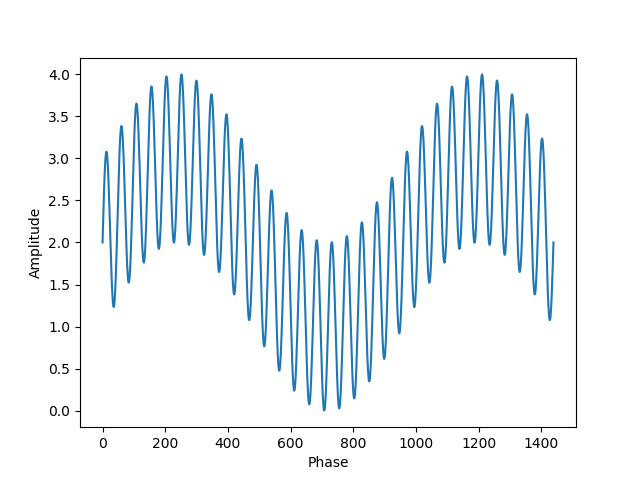

Bei der klassischen Zeitreihenanalyse ist es das Ziel, die Frequenzen der Schwingungen zu bestimmen und meist noch in ein Modell (periodisches Modell) zu überführen. Das Vorgehen bei der klassischen Zeitreihenanalyse haben wir bereits in den Übungen zur Zeitreihenanalyse kennengelernt. Dieses Wissen sollten wir im Folgenden nutzen, um sowohl Parallelen als auch Unterschiede hierzu zu sehen. Wir haben damals viele Überlegungen in die Modellbildung angestellt und uns gefragt, wie wir die Schwingungen kombinieren oder das Rauschen loswerden.


In dieser Übung wollen wir „einfach nur" prognostizieren wie sich der Verlauf der Messwerte fortschreibt. 


Klingt einfach? 


Hierfür wird ein **künstliches neuronales Netz (KNN)** entwickelt, um den zukünftigen Verlauf der (Mess)werte bestmöglich zu beschreiben. Wir haben kein Wissen über die Schwingungen, kein Wissen über Parameter und kein parametrisiertes Modell... nur die Messwerte.

Los geht es!



# KNN für Zeitreihen

Diese Übung werden wir mit Hilfe eines **Python-Skriptes** bewältigen. Ich habe dafür ein geläufiges Programm zusammengestellt. Teile des Codes sind dem Blog [Time Series Prediction with LSTM ...](https://machinelearningmastery.com/time-series-prediction-lstm-recurrent-neural-networks-python-keras/) entnommen. In diesem Blog wird das KNN noch erweitert. Lasst uns aber erstmal verstehen, wie das KNN funktioniert und wie wir eines selber programmieren können.

In dieser Übung möchte ich nicht die Theorie und auch nicht das Konzept eines **Long Short Term Memory** KNN erläutern. Das heben wir uns für später auf. Wir bleiben hier beim allgemeinen Konzept. Für alle die mehr wissen wollen, verweise ich für den Einstieg an den Blog: [Deep Learning - ANN, RNN, LSTM networks](http://vishnuviswanath.com/ann_rnn_lstm.html).

Wir nutzen für diese Übung fünf verschiedene Pakete (APIs). Einige Pakete sind sicherlich bekannt, andere sind vielleicht neu für euch. Alle Pakete sind aber gut dokumentiert, sodass ihr euch selber schnell viele Fragen beantworten könnt.

>**numpy** as np verwaltet unsere Messwerte in Arrays mit n Dimensionen. Neben dem cleveren Speichern der Messwerte und dem schnellen Zugriff, können wir mit np das Feld der Matrizenrechnung abdecken.

>**matplotlib.pylpt** as plt nutzten wir, um Abbildungen bzw. Graphen von unseren Daten zu erstellen. 

>**math** ermöglicht uns einfache Operationen bei Anwendung von skalaren Werten, Listen oder anderen „einfachen“ Datenformaten. Eine solche Operation ist zu Beispiel das Quadrieren einer Zahl.

>**sklearn** fasst viele nützliche Werkzeuge zusammen, die wir beim Maschinen Learning (ML) brauchen. Insbesondere um unsere Daten „in Form“ zu bringen. Z. B. durch das Normieren der Messwerte oder das Aufteilen in Subsets (für das Training und für das Testen). Bei Fragen hierzu gerne [hier](https://scikit-learn.org/stable/) vorbei schauen.

>**keras** ist hier unser ML-Tool, mit dem wir das KNN bauen. Es nutzt im Hintergrund ein anderes Paket (Tensorflow), um die komplexen (Matrizen)-Berechnungen durchzuführen. Ich finde keras übersichtlich und für unsere Anwendung hat es keinen Nachteil. Zur Doku geht es [hier](https://keras.io/).


In [3]:
import numpy as np

import matplotlib.pyplot as plt

import math

from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.layers import LSTM

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
#import tensorflow.compat.v1 as tf
#tf.disable_v2_behavior()

Eigentlich würden wir hier jetzt die Messwerte importieren. Damit wir flexibel unsere Messwerte verändern können, nutzen wir in dieser Übung keine echten Messwerte, sondern programmieren eine Funktion, mit der wir zwei beliebige Sinus-Schwingungen kombinieren können. Die Grundgleichung ist:

>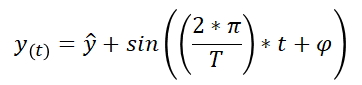

Wobei *y-Dach* die maximale Amplitude, *Phi* die Verschiebung der Phasenfrequenz, *T* die Schwingungsdauer und *t* die aktuelle Zeit ist. Unser Datensatz besteht aus einer lang- und einer kurzwelligen Schwingung. Zusätzlich packen wir noch etwas zufälliges Rauschen dazu. Diese Werte können und sollen im Verlauf der Übung verändert werden. Erstmal lassen wir aber alle Werte so wie sie sind.

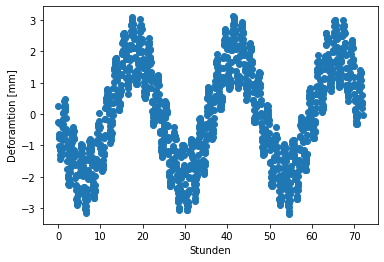

In [6]:
x = np.linspace(0.0, 72.0, num=1440)
dataset = 2 * np.sin((2 * np.pi / (1/60))* x +np.pi) + np.sin((2 * np.pi / 2)* x -np.pi) + np.random.randn(1440) *00.1
# show the data 
plt.xlabel('Stunden')
plt.ylabel('Deforamtion [mm]')
plt.scatter(x,dataset)
plt.show()


Nachdem wir nun unsere „realen“ Übungsdaten haben, müssen wir uns auch gleich von diesen verabschieden. Denn diese Daten sind für ein KNN nicht geeignet. Wenn die Werte sehr groß sind, funktioniert die *Backpropagation* (das Lernen) nicht mehr, da die Gewichte zwischen den Knoten sehr groß werden. Ein Verkleinern der Gewichte ist dann fast nicht mehr möglich.

Um unser KNN gut trainieren zu können, normieren wir zunächst unsere Messwerte, dadurch gehen keine Informationen verloren und unsere Sinusschwingung schwingt nun zwischen 0 und 1.

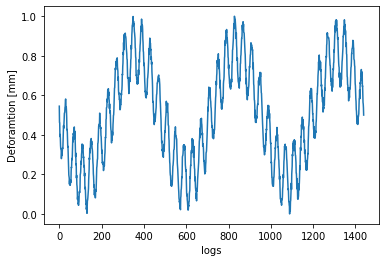

In [7]:
dataset = dataset.astype('float32').reshape([-1, 1])
# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)
# show the data 
plt.xlabel('logs')
plt.ylabel('Deforamtion [mm]')
plt.plot(dataset)
plt.show()

Die zentrale Aufgabe des KNN ist es, aus **Messwerten der Vergangenheit (dem Wissen) eine Vorhersage für die Messwerte in der Zukunft zu machen**. D. h., ich gebe dem Netz einen Messewert zum Zeitpunkt *t* und das Netz soll mir den Wert für *t+1* vorhersagen.  

Um diese Beziehung zu lernen, müssen wir die Daten einmal klonen, den ersten Wert wegwerfen und um eins in der Zeit zurück zu verschieben. Genau das machen wir mit der folgenden Funktion. So haben wir eine Eingabe (datasetX) und Zieldaten (datasetY) für das KNN.

Da es sehr ungünstig sein kann, nur aus dem letzten Wert die Vorhersage zu machen, halten wir die Funktion so, dass wir die Anzahl der Werte in der Vergangenheit variieren können (Parameter: look_back)

In [8]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - look_back - 1):
        a = dataset[i:(i + look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

# reshape into X=t and Y=t+1
look_back = 40
datasetX, datasetY = create_dataset(dataset, look_back)
print('shape input ',datasetY.shape)
print('shape GT ',datasetX.shape)

shape input  (1399,)
shape GT  (1399, 40)


Die Eingabe- und Zieldaten müssen jetzt jeweils in Trainings- und Testdaten unterteilt werden. Aus den Trainingsdaten wird das Wissen erlernt und mit den Testdaten wird unabhängig überprüft, wie gut die Beziehung gelernt werden kann.

Als Faustregel sollten etwa 30% der Daten für die Validierung und die Evaluierung verwendet werden. Mittels der Funktion *train_test_split* können wir einfach untersuchen, was passiert, wenn mehr oder weniger Daten für das Training verwendet werden (Parameter: *train_size*).

Da wir ja aus mehreren Messwerten eine Vorhersage machen wollen, müssen wir das Eingabeformat so anpassen, dass n Werte gleichzeitig ins Netz gegeben werden. Dafür nutzen wir für das Array die *Reshape*-Funktion und bilden einen Eingabevektor. Das bitte nicht mit dem Parameter *batch* verwechseln.



In [9]:
# split test and training data
trainX, testX, trainY, testY = train_test_split(datasetX, datasetY, train_size=0.9, shuffle=False)

# reshape input to be [samples, time steps, features]

trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
testX = np.reshape(testX, (testX.shape[0], testX.shape[1], 1))

Nun können wir **endlich** mit dem KNN loslegen!

Das KNN bekommt jetzt den Namen *model*. Das klingt vielleicht etwas irreführend, macht aber Sinn, wenn wir uns an die Diskussion in der Einleitung dieser Übung erinnern.

Also bleiben wir beim *model*, das nicht nur die Architektur (Anordnung der Knoten des KNN und Funktionen), sondern auch die Gewichte umfasst. 

Als grundsätzliche Architektur wählen wir *sequentail*. Dies ist für Daten, die gereiht bzw. zeitlich geordnet werden können, eine gute Wahl. Daten werden ins KNN gegeben und der folgende Wert wird vorhergesagt.

In das *sequentail model*  hängen wir nun verschiedene Layer, also Schichten, in denen die Messwerte verarbeitet werden. In jeder Schicht haben wir Knoten, die über Gewichte verbunden sind. Die Gewichte drücken das Wissen aus. 

LSTM steht für Long Short Term Memory. Ganz einfach gesagt: Die Werte durchlaufen n Mal eine Schicht, um die Merkmale zu bestimmen, die unsere Zeitreihe beschreiben.

Diese Merkmale werden hier durch die folgende Schicht, in diesem Fall bereits die Ausgabeschicht, zusammengefasst. *Dense* steht für normale Kontenschichten und der Wert in den Klammer gibt an, wie viele Knoten in jeder Schicht sind. Durch den Befehl *summary* können wir uns das *model* anzeigen lassen. 

Der Rahmen für unser Netz steht! 

Beginnen wir nun mit dem Innenausbau. In diesem Fall müssen wir…
*	die Optimierungsfunktionen (wie soll das KNN lernen) festlegen.
*	die Loss-Funktion (Funktion, durch den der Fehler ausgedrückt wird) wählen.
*	sonstige Parameter, die für die Überwachung des Lernerfolges verwendet werden sollen, festlegen.

Mit *compile* fügen wir all diese Informationen zum Rahmen hinzu und bauen das KNN auf. Damit das KNN eine Vorhersage machen kann, muss es trainiert werden.
Wie es trainiert wird, das haben wir in der Vorlesung gehört und soll hier nicht weiter vertieft werden.


In [10]:
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(88, input_shape=(look_back, 1)))
model.add(Dense(1))
model.summary()
model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mae'])  # 


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 88)                31680     
_________________________________________________________________
dense (Dense)                (None, 1)                 89        
Total params: 31,769
Trainable params: 31,769
Non-trainable params: 0
_________________________________________________________________


Die nächste Zeile des Codes startet das Training. Das KNN wird für seine Aufgabe *„fit“* gemacht. Neben den Parametern Eingabe- und Zieldaten können wir noch entscheiden, wie wir das KNN trainieren wollen. Im Übungsbeispiel haben wir folgende Parameter:
>**epochs:** Das Training des KNN ist ein interaktiver Prozess der, welcher beendet wird, wenn eine bestimmte Anzahl an Epochen durchgeführt wurde. Alternativ kann auch ein Stagnieren der Loss Funktion als Abbruchkriterium verwendet werden.

>**batch_size:** *Batch* ist ein Stapel aus Trainingswerten oder -vektoren der durch das KNN geben wird, ohne dass die Gewichte aktualisiert werden. Durch die Batches wird das Training effizienter und nicht jeder kleine Ausreißer in den Messwerten wird berücksichtigt, sodass das KNN eher allgemeine Merkmale lernt (es generalisiert).

>**validation_data:** Während des Trainings wird überprüft, ob das Netz noch besser wird, stagniert oder gar schlechter wird. Stichworte sind *underfitting* und *overfitting*. Um das schon während des Trainings beurteilen zu können wird auch schon mit unabhängigen Daten getestet, wie das KNN die Beziehung erlernt.

>**verbose:** Dieser Parameter steuert, wie der Trainingsprozess visualisiert wird.

Es gibt noch weitere Parameter, die hier eingestellt werden können. Schaut euch das gerne mal genauer an. 
 [Keras API fit](https://keras.io/models/model/) 


In [11]:
history = model.fit(trainX, trainY, epochs=60, batch_size=10,validation_data=(testX, testY), verbose=2)

Epoch 1/60
126/126 - 5s - loss: 0.0150 - mae: 0.0913 - val_loss: 0.0050 - val_mae: 0.0578
Epoch 2/60
126/126 - 2s - loss: 0.0015 - mae: 0.0306 - val_loss: 9.7145e-04 - val_mae: 0.0261
Epoch 3/60
126/126 - 2s - loss: 5.4042e-04 - mae: 0.0186 - val_loss: 4.0324e-04 - val_mae: 0.0162
Epoch 4/60
126/126 - 2s - loss: 4.1705e-04 - mae: 0.0162 - val_loss: 6.7450e-04 - val_mae: 0.0215
Epoch 5/60
126/126 - 2s - loss: 4.2913e-04 - mae: 0.0165 - val_loss: 4.3439e-04 - val_mae: 0.0170
Epoch 6/60
126/126 - 2s - loss: 4.3468e-04 - mae: 0.0165 - val_loss: 0.0015 - val_mae: 0.0343
Epoch 7/60
126/126 - 2s - loss: 4.9302e-04 - mae: 0.0175 - val_loss: 0.0011 - val_mae: 0.0283
Epoch 8/60
126/126 - 2s - loss: 4.6642e-04 - mae: 0.0171 - val_loss: 3.4807e-04 - val_mae: 0.0147
Epoch 9/60
126/126 - 2s - loss: 4.2333e-04 - mae: 0.0163 - val_loss: 0.0016 - val_mae: 0.0349
Epoch 10/60
126/126 - 2s - loss: 4.5796e-04 - mae: 0.0170 - val_loss: 4.9209e-04 - val_mae: 0.0180
Epoch 11/60
126/126 - 2s - loss: 4.7986e-04

Als *loss*-Funktion haben wir den *MSE (mean_squared_error)* verwendet. Wie hat sich dieser über das Training für die Trainings- und Validierungswerte verändert? 

In Variable *history* haben wir diese Informationen gespeichert. Wir erwarten, dass das LOSS MSE immer kleiner wird und dass die Trainingsdaten ein wenig besser sind als die Validierungsdaten.


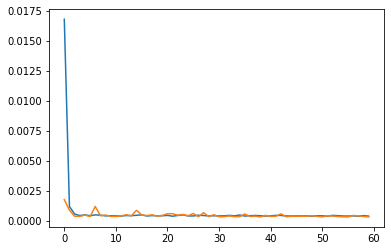

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.show()

#Wir haben nun **unser erstes trainiertes KNN**.



Im Folgenden wollen wir unser erstes trainiertes KNN anwenden und den RMS-Error für die Trainingsdaten und die Testdaten berechnen. Zugegeben, das hat das keinen praktischen Sinn.  Wir testen vielmehr, wie gut das KNN bei bekannten Daten und optimalen Bedingungen arbeitet. Wenn wir die Leistung und die einzelnen Stellschrauben des KNN kennenlernen und bewerten wollen, dann ist das aber ein guter Weg. Testet gerne was passiert, wenn ihr die Parameter verändert. 
Die beiden folgenden Blöcke sind eigentlich ein Block. Da aber vom normierten Wertebereich zum wahren Wertebereich nur einmal transformiert werden kann, habe ich den Block geteilt, damit man den zweiten Block immer wieder neu berechnen kann. Auch hier kann man „spielen“. 

Was ist hier passiert? 

Wir…
* ...nutzen die Test- und Trainingsdaten in der *predict*-Funktion des *model*.
* ...transformieren die vorhergesagten Werte in den wahren Wertebereich.
* ...berechnen den RMS-Error.
* ...schieben die Zeitreihenstücke an die richtige Stelle.
* ...visualisieren das Ganze.

*Hinweis:* Dieser Teile ist dem Blog [Time Series Prediction with LSTM ...](https://machinelearningmastery.com/time-series-prediction-lstm-recurrent-neural-networks-python-keras/) entnommen. Da es gut funktioniert, habe ich es nicht verändert.

In [ ]:
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

# invert predictions  from norm to real
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])



Train Score: 0.12 RMSE
Test Score: 0.11 RMSE


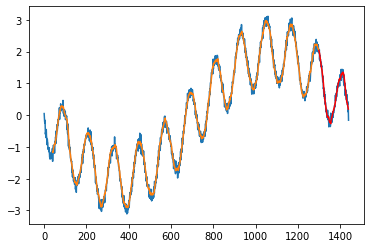

In [ ]:

# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:, 0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:, 0]))
print('Test Score: %.2f RMSE' % (testScore))

# shift train predictions for plotting
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict) + look_back, :] = trainPredict

# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict) + (look_back * 1) + 0:len(dataset) - 1, :] = testPredict

# plot baseline and predictions
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot,c='r')
plt.show()

**Das sieht doch ganz gut aus, oder?**

Das ja, aber ergibt das auch Sinn?

Nein! Wie ihr sicher schon bemerkt habt, ergibt diese Anwendung für die Praxis wenig Sinn. Wenn ich erst dann eine Vorhersage erhalte, wenn ich eh schon die Werte gemessen habe, dann kann ich es auch lassen.

Eigentlich will ich ja möglichst weit in die Zukunft schauen und das nur mit dem Wissen aus der Vergangenheit. Also bauen wir die Daten erneut etwas um, sodass immer der letzte vorhergesagte Wert zum ersten Eingabewert des KNN wird (**Iterative Vorhersage**). 

Wir rechnen also iterativ immer weiter. Aufbauend auf unseren Vorhersagen. Euch ist sicherlich schon klar, dass das Ergebnis nun deutlich schlechter werden wird als beim Prüfen mit den Daten oben.


(140, 40, 1)
[array([0.7421132], dtype=float32), array([0.76611364], dtype=float32), array([0.73545873], dtype=float32), array([0.7703223], dtype=float32), array([0.75685954], dtype=float32), array([0.7674603], dtype=float32), array([0.77423596], dtype=float32), array([0.77771544], dtype=float32), array([0.8171965], dtype=float32), array([0.8154429], dtype=float32), array([0.7698195], dtype=float32), array([0.8185655], dtype=float32), array([0.7881129], dtype=float32), array([0.83836174], dtype=float32), array([0.83725774], dtype=float32), array([0.8409295], dtype=float32), array([0.83054817], dtype=float32), array([0.86017585], dtype=float32), array([0.8613879], dtype=float32), array([0.8110126], dtype=float32), array([0.847227], dtype=float32), array([0.8380671], dtype=float32), array([0.8558686], dtype=float32), array([0.8635354], dtype=float32), array([0.855993], dtype=float32), array([0.84179723], dtype=float32), array([0.8829251], dtype=float32), array([0.8597801], dtype=float32)

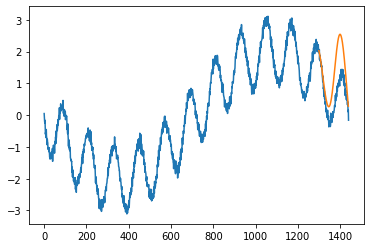

In [ ]:
testPredictList = []
print(testX.shape)
for j in range(1,look_back):
    testPredictList.append(testX[0][j])
#testPredictList= sum(testPredictList,[])
#testPredictList.append(.reshape(2))
w = np.reshape(testX[0], (1, look_back, 1))
for i in range(0, len(testX)):
    testPredictV = model.predict(w)
    testPredictList.append(testPredictV[0])
    w = np.array([testPredictList[-look_back:]])
    #w = np.array([[testPredictList[-3],testPredictList[-2],testPredictList[-1]]])
print(list(testPredictList))

testPredictList = scaler.inverse_transform(np.reshape(testPredictList, (len(testPredictList), 1)))

testPredictPlotList = np.empty_like(dataset)
testPredictPlotList[:, :] = np.nan


testPredictPlotList[len(trainPredict) + (look_back * 1) + 0:len(dataset) - 1, :] = testPredictList[look_back-1:]

# plot baseline and predictions
plt.plot(scaler.inverse_transform(dataset))
plt.plot(testPredictPlotList)
plt.show()

Wie wir sehen, ist es das auch so.

Anfänglich passt die Vorhersage noch sehr gut, doch schon nach einigen Werten nimmt die Kurve einen anderen Verlauf an als die wahren Messwerte. 

* Warum ist das so? 
* Welche Möglichkeiten haben wir, die Leistung das KNN zu verbessern? 

Diese Fragen sollt ihr in euren Berichten beantworten.

**Im Aufgabenteil geht es nun weiter. Nutzt dieses Notebook, um die Fragen zu beantworten. Ihr braucht nichts zu programmieren, sondern nur einzelne Werte ändern und die Beobachtungen beschreiben, interpretieren und bewerten.**



# Aufgabe (PVL)

In der Onlineübung habe ich am Beispiel zweier aufaddierter Sinusschwingungen gezeigt, wie ein KNN für die Vorhersage von Messwerten entwickelt und angewendet werden kann. Mit diesem Beispiel soll nun untersucht werden, wie die interaktive Vorhersage verbessert werden kann. Dafür müssen verschiedene Stellschrauben (Parameter) des KNN angepasst werden. Ein paar Hinweise habe ich in der Beschreibung schon gegeben.

Mögliches Vorgehen: 

•	Mache dich damit vertraut, welche Parameter vorhanden sind.

•	Versuche experimentell und durch Literaturrecherche zu verstehen, welche Parameterwerte plausibel sind und wie diese Parameter wirken.

•	Finde die optimalen Einstellungen in Bezug und begründe diese.

•	Beschreibe und diskutiere deine Beobachtungen und gib einen Ausblick für die nächsten Erweiterungen des KNN. 

Formalien: 
Das Vorgehen und die Untersuchungen sind in einem kurzen Bericht (5 Seiten mit Abbildungen plus Inhalts-, Literaturverzeichnis und Deckblatt) darzustellen. Der Bericht ist bis zum **22.06.2020 (23:59 Uhr)** an eike.barnefske@hcu-hamburg.de zu senden. Der Betreff der E-Mail ist: *Inggeo II Übung 3*.


